# Working with the ECCC GeoAPI to access weather station data

Environment and Climate Change Canada (ECCC) hosts a data server compatible with the [GeoAPI](https://www.geoapi.org/) standard. This notebook shows how to send requests for daily climate station data and display the results.

## Climate stations

The server holds different [*collections*](https://api.weather.gc.ca/collections?f=html), and requests are made to a particular collection. Here we'll start with the `climate-station` collection, which holds metadata about available stations, but no actual meteorological data. Useful [queryables fields](https://api.weather.gc.ca/collections/climate-stations/queryables) in this collection include `DLY_FIRST_DATE` and `DLY_LAST_DATE`, `ENG_PROV_NAME`, `LATITUDE`, `LONGITUDE` and `ELEVATION` and `STATION_NAME`, among many others.

### Creating a request to the server for data

Let's start by showing a map of all available stations locations in New-Brunswick. To do so, we first need to compose a URL request. The request includes the address of the server, the collection, then a query to filter results.

In [1]:
import os

os.environ["USE_PYGEOS"] = "0"  # force use Shapely with GeoPandas

import urllib

import geopandas as gpd
from urlpath import URL

# Compose the request
host = URL("https://api.weather.gc.ca")
climate_stations = host / "collections" / "climate-stations" / "items"
url = climate_stations.with_query({"ENG_PROV_NAME": "NOVA-SCOTIA"})
print(url)

# Send the request to the server
resp = url.get()
resp

https://api.weather.gc.ca/collections/climate-stations/items?ENG_PROV_NAME=NOVA-SCOTIA


<Response [200]>

The response from the server is a `Response` class instance. What we're interested in is the content of this response, which in this case is a geoJSON file.

In [2]:
# NBVAL_IGNORE_OUTPUT

resp.content[:100]

b'{"type":"FeatureCollection","features":[{"type":"Feature","properties":{"STN_ID":6288,"STATION_NAME"'

We'll open the geoJSON using geopandas. We have a few options to do this:
- Load the response' content using `json.load`, then create GeoDataFrame using the `from_features` class method;
- Save the response content to a file on disk, then open using `geopandas.read_file`;
- Save the response in an in-memory file using `StringIO`;
- Call `geopandas.read_file(url)` to let geopandas handle the data download.

Here we'll use the last option, as it's the simplest. Note that the first method ignores the feature `id`, which seems to create problems with visualization with folium below.

In [3]:
# NBVAL_IGNORE_OUTPUT

# The first approach would look like this:
# import json
# stations = gpd.GeoDataFrame.from_features(json.loads(resp.content))

with urllib.request.urlopen(url=str(url)) as req:
    stations = gpd.read_file(filename=req, engine="fiona")
stations.head()

,id,STN_ID,STATION_NAME,PROV_STATE_TERR_CODE,ENG_PROV_NAME,FRE_PROV_NAME,COUNTRY,LATITUDE,LONGITUDE,TIMEZONE,...,HLY_FIRST_DATE,HLY_LAST_DATE,DLY_FIRST_DATE,DLY_LAST_DATE,MLY_FIRST_DATE,MLY_LAST_DATE,HAS_MONTHLY_SUMMARY,HAS_NORMALS_DATA,HAS_HOURLY_DATA,geometry
0,8200015,6288,ABERCROMBIE POINT,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,453900000,-624300000,AST,...,NaT,NaT,1973-09-01,1978-12-31,1973-01-01,1978-12-01,Y,N,N,POINT (-62.71667 45.65)
1,8200100,6289,ANNAPOLIS ROYAL,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,444500000,-653100000,AST,...,NaT,NaT,1914-04-01,2007-06-04,1914-01-01,2006-02-01,Y,N,N,POINT (-65.51667 44.75)
2,8200150,6290,ANTIGONISH,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,453800000,-615800000,AST,...,NaT,NaT,1880-12-01,1947-12-31,1880-01-01,1947-12-01,Y,N,N,POINT (-61.96667 45.63333)
3,8200151,6291,ANTIGONISH,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,453700000,-615900000,AST,...,NaT,NaT,1979-07-01,1982-12-31,1979-01-01,1982-12-01,Y,N,N,POINT (-61.98333 45.61667)
4,8200155,6292,APRIL BROOK IHD,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,461400000,-610800000,AST,...,NaT,NaT,1966-12-01,1976-01-31,1966-01-01,1976-12-01,Y,N,N,POINT (-61.13333 46.23333)


### Filter stations

Now let's say we want to filter the stations that were in operations for at least 50 years. What we'll do is create a new column `n_days` and filter on it.

In [4]:
# NBVAL_IGNORE_OUTPUT

import pandas as pd

# Create a datetime.Timedelta object from the subtraction of two dates.
delta = pd.to_datetime(stations["DLY_LAST_DATE"]) - pd.to_datetime(
    stations["DLY_FIRST_DATE"]
)

# Get the number of days in the time delta
stations["n_days"] = delta.apply(lambda x: x.days)

# Compute condition
over_50 = stations["n_days"] > 50 * 365.25

# Index the data frame using the condition
select = stations[over_50]
select.head()

,id,STN_ID,STATION_NAME,PROV_STATE_TERR_CODE,ENG_PROV_NAME,FRE_PROV_NAME,COUNTRY,LATITUDE,LONGITUDE,TIMEZONE,...,HLY_LAST_DATE,DLY_FIRST_DATE,DLY_LAST_DATE,MLY_FIRST_DATE,MLY_LAST_DATE,HAS_MONTHLY_SUMMARY,HAS_NORMALS_DATA,HAS_HOURLY_DATA,geometry,n_days
1,8200100,6289,ANNAPOLIS ROYAL,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,444500000,-653100000,AST,...,NaT,1914-04-01,2007-06-04,1914-01-01,2006-02-01,Y,N,N,POINT (-65.51667 44.75),34032
2,8200150,6290,ANTIGONISH,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,453800000,-615800000,AST,...,NaT,1880-12-01,1947-12-31,1880-01-01,1947-12-01,Y,N,N,POINT (-61.96667 45.63333),24500
6,8200200,6294,AVON,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,445300000,-641300000,AST,...,NaT,1949-11-01,2001-01-31,1949-01-01,2001-01-01,Y,N,N,POINT (-64.21667 44.88333),18719
9,8200300,6297,BADDECK,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,460600000,-604500000,AST,...,NaT,1875-06-01,2000-01-31,1875-01-01,2000-01-01,Y,N,N,POINT (-60.75 46.1),45534
12,8200500,6300,BEAR RIVER,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,443400000,-653800000,AST,...,NaT,1952-11-01,2006-02-28,1952-01-01,2006-02-01,Y,Y,N,POINT (-65.63333 44.56667),19477


### Map the data

We can then simply map the locations of station with at least 50 years of data using the `explore` method. This will display an interactive base map and overlay the station locations, where on a station marker will display this station's information.

On top of this map, we'll add controls to draw a rectangle. To use the drawing tool, click on the square on the left hand side menu, and the click and drag to draw a rectangle over the area of interest. Once that's done, click on the Export button on the right of the map. This will download a file called `data.geojson`

In [5]:
from folium.plugins import Draw

# Add control to draw a rectangle, and an export button.
draw_control = Draw(
    draw_options={
        "polyline": False,
        "poly": False,
        "circle": False,
        "polygon": False,
        "marker": False,
        "circlemarker": False,
        "rectangle": True,
    },
    export=True,
)

# The map library Folium chokes on columns including time stamps, so we first select the data to plot.
m = select[["geometry", "n_days"]].explore("n_days")
draw_control.add_to(m)
m

### Filter stations using bounding box

Next, we'll use the bounding box drawn on the map to select a subset of stations. We first open the `data.geojson` file downloaded to disk, create a shapely object and use it filter stations.

In [6]:
# NBVAL_IGNORE_OUTPUT

# Adjust directory if running this locally.
# rect = gpd.read_file("~/Downloads/data.geojson")

# Here we're using an existing file so the notebook runs without user interaction.
rect = gpd.read_file(filename="./data.geojson", engine="fiona")

# Filter stations DataFrame using bbox
inbox = select.within(rect.loc[0].geometry)

print("Number of stations within subregion: ", sum(inbox))
sub_select = select[inbox]
sub_select.head()

Number of stations within subregion:  9


,id,STN_ID,STATION_NAME,PROV_STATE_TERR_CODE,ENG_PROV_NAME,FRE_PROV_NAME,COUNTRY,LATITUDE,LONGITUDE,TIMEZONE,...,HLY_LAST_DATE,DLY_FIRST_DATE,DLY_LAST_DATE,MLY_FIRST_DATE,MLY_LAST_DATE,HAS_MONTHLY_SUMMARY,HAS_NORMALS_DATA,HAS_HOURLY_DATA,geometry,n_days
2,8200150,6290,ANTIGONISH,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,453800000,-615800000,AST,...,NaT,1880-12-01,1947-12-31,1880-01-01,1947-12-01,Y,N,N,POINT (-61.96667 45.63333),24500
9,8200300,6297,BADDECK,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,460600000,-604500000,AST,...,NaT,1875-06-01,2000-01-31,1875-01-01,2000-01-01,Y,N,N,POINT (-60.75 46.1),45534
41,8201000,6329,COLLEGEVILLE,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,452900000,-620100000,AST,...,NaT,1916-06-01,2016-09-30,1916-01-01,2006-02-01,Y,Y,N,POINT (-62.01667 45.48333),36646
48,8201410,6336,DEMING,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,451259007,-611040090,AST,...,NaT,1956-10-01,2011-12-31,1956-01-01,2006-02-01,Y,Y,N,POINT (-61.1778 45.21639),20179
153,8204480,6441,PORT HASTINGS,NS,NOVA SCOTIA,NOUVELLE-ÉCOSSE,CAN,453800000,-612400000,AST,...,NaT,1874-01-01,1989-09-30,1874-01-01,1989-12-01,Y,N,N,POINT (-61.4 45.63333),42275


### Request meteorological data

Now we'll make a request for actual meteorological data from the stations filtered above. For this, we'll use the
Daily Climate Observations collection (`climate-daily`). Here, we're picking just one station but we could easily loop on each station.

In [7]:
# NBVAL_IGNORE_OUTPUT

coll = host / "collections" / "climate-daily" / "items"
station_id = "8201410"

# Restricting the number of entries returned to keep things fast.
url = str(coll.with_query({"CLIMATE_IDENTIFIER": station_id, "limit": 365}))
print("Request: ", url)
with urllib.request.urlopen(url=str(url)) as req:
    data = gpd.read_file(filename=req, engine="fiona")
data.head()

Request:  https://api.weather.gc.ca/collections/climate-daily/items?CLIMATE_IDENTIFIER=8201410&limit=365


,id,PROVINCE_CODE,HEATING_DEGREE_DAYS_FLAG,SNOW_ON_GROUND_FLAG,MEAN_TEMPERATURE_FLAG,DIRECTION_MAX_GUST_FLAG,LOCAL_DAY,MAX_REL_HUMIDITY_FLAG,MAX_TEMPERATURE,MAX_REL_HUMIDITY,...,SPEED_MAX_GUST,CLIMATE_IDENTIFIER,MAX_TEMPERATURE_FLAG,COOLING_DEGREE_DAYS,MIN_REL_HUMIDITY,LOCAL_DATE,COOLING_DEGREE_DAYS_FLAG,MIN_TEMPERATURE,MEAN_TEMPERATURE,geometry
0,8201410.1996.6.13,NS,None,None,None,None,13,None,12.5,None,...,None,8201410,None,0.0,None,1996-06-13,None,9.0,10.8,POINT (-61.1778 45.21639)
1,8201410.1993.12.17,NS,None,None,None,None,17,None,0.5,None,...,None,8201410,None,0.0,None,1993-12-17,None,-2.5,-1.0,POINT (-61.1778 45.21639)
2,8201410.1967.11.6,NS,None,None,None,None,6,None,8.9,None,...,None,8201410,None,0.0,None,1967-11-06,None,3.9,6.4,POINT (-61.1778 45.21639)
3,8201410.2003.1.14,NS,None,None,None,None,14,None,-3.5,None,...,None,8201410,None,0.0,None,2003-01-14,None,-6.0,-4.8,POINT (-61.1778 45.21639)
4,8201410.2009.1.30,NS,None,None,None,None,30,None,-1.0,None,...,None,8201410,None,0.0,None,2009-01-30,None,-5.5,-3.3,POINT (-61.1778 45.21639)


We can also send a request for data inside a bounding box at a specific date.

In [8]:
bbox = rect.iloc[0].geometry.bounds
print("Bounding box: ", bbox)
url = str(
    coll.with_query(
        {
            "bbox": str(bbox).strip("()"),
            "LOCAL_DATE": "2000-01-01 00:00:00",
            "limit": 100,
        }
    )
)
with urllib.request.urlopen(url=str(url)) as req:
    snapshot = gpd.read_file(filename=req, engine="fiona")

Bounding box:  (-62.186675, 44.78125, -59.123882, 47.53125)


Text(448.07777777777784, 0.5, 'Mean temperature [°C]')

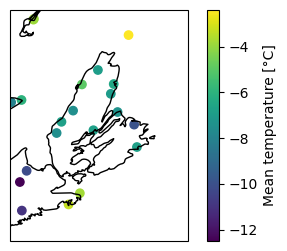

In [9]:
import cartopy
from cartopy import crs as ccrs
from matplotlib import pyplot as plt

# Create map projection
proj = ccrs.PlateCarree()

# If using another projection, remember you'll need to reproject the snapshot's coordinates.
# snapshot.to_crs(proj, inplace=True)

# Create figure and axes
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(projection=proj)

# Set the map extent to the bounding box and draw the coastlines
ax.set_extent([bbox[0], bbox[2], bbox[1], bbox[3]])
ax.coastlines()

# Plot markers color-coded according to the temperature recorded.
ax = snapshot.plot(column="MEAN_TEMPERATURE", ax=ax, cmap=plt.cm.viridis, legend=True)

# Add a label to the colorbar
cax = ax.figure.axes[-1]
cax.set_ylabel("Mean temperature [°C]")

Another useful filter is on dates and times. Let's say we only want data in a given period, we simply create a request with the `datetime` argument and a `/` separating the start and end dates. You may leave the start or end date open-ended using `..` instead of a date time string.

In [10]:
url = str(
    coll.with_query(
        {
            "CLIMATE_IDENTIFIER": station_id,
            "datetime": "1990-01-01 00:00:00/1991-01-01 00:00:00",
        }
    )
)
print(url)
with urllib.request.urlopen(url=str(url)) as req:
    gdf = gpd.read_file(filename=req, engine="fiona")

https://api.weather.gc.ca/collections/climate-daily/items?CLIMATE_IDENTIFIER=8201410&datetime=1990-01-01+00%3A00%3A00%2F1991-01-01+00%3A00%3A00


In [11]:
# Convert the datetime string to a datetime object
gdf["LOCAL_DATE"] = pd.to_datetime(gdf["LOCAL_DATE"])

# Create a time series out of the column for mean temperature
ts = gdf.set_index("LOCAL_DATE")["MEAN_TEMPERATURE"]

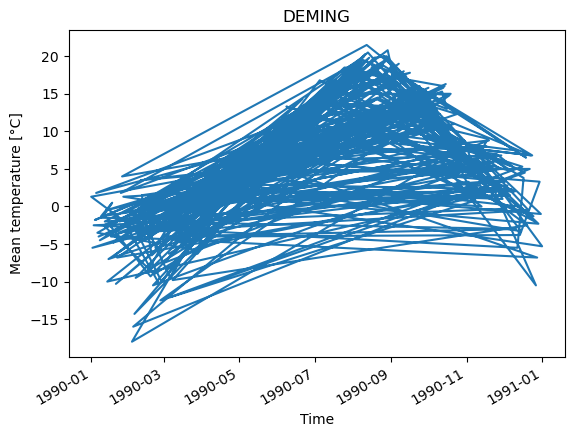

In [12]:
# Plot the time series
ax = ts.plot()
ax.set_xlabel("Time")
ax.set_ylabel("Mean temperature [°C]")
ax.set_title(gdf.iloc[0]["STATION_NAME"])
plt.show()

## Adjusted and Homogenized Canadian Climate Data (AHCCD)

The Adjusted and Homogenized Canadian Climate Data (AHCCD) datasets from ECCC are climate station data adjusted to account for discontinuities in the record, such as instrument relocation. The collections related to these datasets are `ahccd-stations` for station metadata, `ahccd-annual`, `ahccd-monthly` and `ahccd-seasonal` for temporally aggregated time series, and `ahccd-trends` for trends computed on the data.

Now, unfortunately, the fields for these datasets are different from those of the climate stations... One strategy to find out what keywords are accepted is to make a query with no filter except for `limit=1`. Another is to go to the collection search page (click on the link printed below), and inspect the column names.

In [13]:
# NBVAL_IGNORE_OUTPUT

# The url to query station metadata - this should behave similarly as `climate-stations`
ahccd_stations = host / "collections" / "ahccd-stations" / "items"
url = ahccd_stations.with_query({"limit": 1})
print(ahccd_stations)
with urllib.request.urlopen(url=str(url)) as req:
    display(gpd.read_file(filename=req, engine="fiona"))

https://api.weather.gc.ca/collections/ahccd-stations/items


,id,identifier__identifiant,station_id__id_station,station_name__nom_station,measurement_type__type_mesure,period__periode,trend_value__valeur_tendance,elevation__elevation,province__province,joined__rejoint,year_range__annees,start_date__date_debut,end_date__date_fin,geometry
0,2400305,2400305,2400305,ALERT,temp_mean,Ann,1.5,65,NU,1,1951-2020,1950-07-01,2020-12-01,POINT (-62.33 82.5)


So if we want to see the stations in Yukon, we'd have to query with the `province__province` keyword... Now how do you know what code to use for provinces? One solution is to go again to the [collection search page](https://api.weather.gc.ca/collections/ahccd-monthly/items), zoom on the area of interest and click on the check box to "Only show items by map view", then inspect the results.

In [14]:
# NBVAL_IGNORE_OUTPUT

url = ahccd_stations.with_query({"province__province": "YT"})
with urllib.request.urlopen(url=str(url)) as req:
    display(gpd.read_file(filename=req, engine="fiona"))

,id,identifier__identifiant,station_id__id_station,station_name__nom_station,measurement_type__type_mesure,period__periode,trend_value__valeur_tendance,elevation__elevation,province__province,joined__rejoint,year_range__annees,start_date__date_debut,end_date__date_fin,geometry
0,2100100,2100100,2100100,AISHIHIK A,pressure_sea_level,Ann,NaN,966.20,YT,0,None,1953-01-01,1966-09-01,POINT (-137.48 61.65)
1,2100160,2100160,2100160,BEAVER CREEK A,pressure_sea_level,Ann,NaN,649.00,YT,1,None,1968-12-01,2014-12-01,POINT (-140.87 62.41)
2,2100400,2100400,2100400,DAWSON,pressure_sea_level,Ann,NaN,320.00,YT,0,None,1953-01-01,1976-01-01,POINT (-139.43 64.05)
3,2100402,2100402,2100402,DAWSON A,pressure_sea_level,Ann,NaN,370.30,YT,1,None,1976-02-01,2014-12-01,POINT (-139.13 64.04)
4,2100517,2100517,2100517,FARO A,pressure_sea_level,Ann,NaN,716.60,YT,1,None,1987-10-01,2014-12-01,POINT (-133.38 62.21)
5,2100636,2100636,2100636,HERSCHEL ISLAND,pressure_sea_level,Ann,NaN,1.20,YT,0,None,1986-10-01,2014-12-01,POINT (-138.91 69.57)
6,2100685,2100685,2100685,KOMAKUK BEACH A,pressure_sea_level,Ann,NaN,7.30,YT,0,None,1973-08-01,1993-06-01,POINT (-140.18 69.58)
7,2100800,2100800,2100800,OLD CROW A,pressure_sea_level,Ann,NaN,251.20,YT,1,None,1975-08-01,2014-12-01,POINT (-139.84 67.57)
8,2100935,2100935,2100935,ROCK RIVER,pressure_sea_level,Ann,NaN,731.00,YT,0,None,1989-09-01,2014-12-01,POINT (-136.22 66.98)
9,2101000,2101000,2101000,SNAG A,pressure_sea_level,Ann,NaN,586.70,YT,0,None,1953-01-01,1966-08-01,POINT (-140.4 62.37)


Let's pick the Dawson station (`2100LRP`), which seems to have a long record. Again, use the trick above to see which fields are accepted.

In [15]:
# NBVAL_IGNORE_OUTPUT

ahccd_mon = host / "collections" / "ahccd-monthly" / "items"
url = ahccd_mon.with_query({"station_id__id_station": "2100LRP"})
with urllib.request.urlopen(url=str(url)) as req:
    mts = gpd.read_file(filename=req, engine="fiona")
mts.head()

,id,temp_min_units__temp_min_unites,pressure_sea_level_units__pression_niveau_mer_unite,date,lat__lat,station_id__id_station,temp_max_units__temp_max_unites,period_group__groupe_periode,wind_speed_units__vitesse_vent_unites,pressure_station_units__pression_station_unites,...,wind_speed__vitesse_vent,snow_units__neige_unites,pressure_station__pression_station,temp_min__temp_min,total_precip_units__precip_totale_unites,period_value__valeur_periode,province__province,total_precip__precip_totale,rain__pluie,geometry
0,2100LRP.1983.03,C,hPa,1983-03,64.07,2100LRP,C,Monthly,kph,hPa,...,None,mm,None,-24.5,mm,Mar,YT,None,None,POINT (-139.13 64.07)
1,2100LRP.1921.03,C,hPa,1921-03,64.07,2100LRP,C,Monthly,kph,hPa,...,None,mm,None,-24.7,mm,Mar,YT,None,None,POINT (-139.13 64.07)
2,2100LRP.1992.06,C,hPa,1992-06,64.07,2100LRP,C,Monthly,kph,hPa,...,None,mm,None,6.4,mm,Jun,YT,None,None,POINT (-139.13 64.07)
3,2100LRP.1938.03,C,hPa,1938-03,64.07,2100LRP,C,Monthly,kph,hPa,...,None,mm,None,-22.9,mm,Mar,YT,None,None,POINT (-139.13 64.07)
4,2100LRP.1963.09,C,hPa,1963-09,64.07,2100LRP,C,Monthly,kph,hPa,...,None,mm,None,0.9,mm,Sep,YT,None,None,POINT (-139.13 64.07)


Now let's plot the mean temperature time series. Note that the server does not necessarily return a continuous time series, and when plotting time series with gaps, matplotlib just draws a continuous line between values. To convey the presence of missing values, here we'll use the `asfreq("MS")` method to fill-in gaps in the time series with explicit missing values.

Text(0, 0.5, 'Mean monthly temperature [°C]')

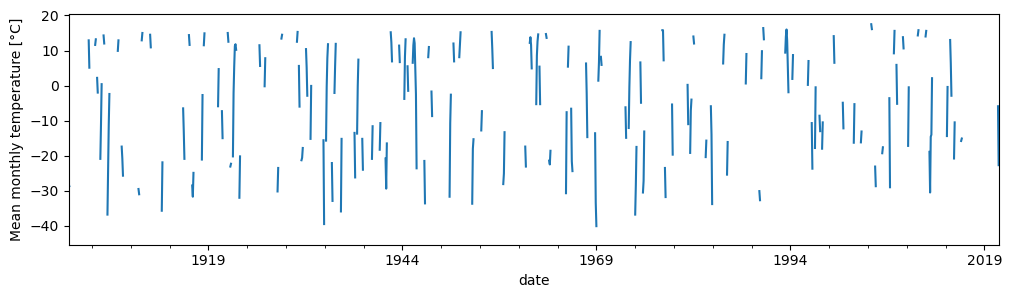

In [16]:
# Set the DataFrame index to a datetime object and sort it
mts.set_index(pd.to_datetime(mts["date"]), inplace=True)
mts.sort_index(inplace=True)

# Convert the temperature to a continuous monthly time series (so missing values are visible in the graphic)
tas = mts["temp_mean__temp_moyenne"].asfreq("MS")

# Mask missing values
tas.mask(tas < -300, inplace=True)

tas.plot(figsize=(12, 3))
plt.ylabel("Mean monthly temperature [°C]")